In [254]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, SMOTENC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate

In [255]:
# Goal: 60% train, 20% validate, 20% test -> 80% train+validate, 20% test

folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [297]:
# Read in files from folders, process images, T2 size, zone info, labels
# clinsig TRUE = 1, FALSE = 0

X_img_t2 = []
X_img_adc = []
X_size_t2 = []
X_size_adc = []
X_zone = []
y = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if zone == 'SV': # only 2 data points have this zone
            continue
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray)) 
        if adc_t2 == 't2':
            X_img_t2.append(array)
            X_size_t2.append(int(size))
            X_zone.append(zone)
            if label == 'TRUE':
                y.append(1)
            else:
                y.append(0)
        else:
            X_img_adc.append(array)
            X_size_adc.append(int(size))
            

# one-hot encode zones, which are categorical features: AS=100, PZ=010, TZ=001
X_zone = LabelBinarizer().fit_transform(X_zone)

# [0,1] min-max T2 size, which are continuous features
X_size_t2 = MinMaxScaler().fit_transform(np.array(X_size_t2).reshape(-1,1))
X_size_adc = MinMaxScaler().fit_transform(np.array(X_size_adc).reshape(-1,1))

In [298]:
X_img_t2 = np.array(X_img_t2)
X_img_adc = np.array(X_img_adc)
y = np.array(y)
print('Original: indolent={}, clinsig={}'.format(Counter(y)[0], Counter(y)[1]))

num, d1, d2, channels = X_img_t2.shape
X_img_t2 = X_img_t2.reshape(num, d1*d2*channels)

num, d1, d2, channels = X_img_adc.shape
X_img_adc = X_img_adc.reshape(num, d1*d2*channels)

X = np.column_stack((X_img_t2, X_img_adc))
X = np.column_stack((X, X_size_t2))
X = np.column_stack((X, X_size_adc))
X = np.column_stack((X, X_zone))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled: indolent={}, clinsig={}\n'.format(Counter(y_res)[0], Counter(y_res)[1]))
print('Flattened: X_res.shape={}, y_res.shape={}]\n'.format(X_res.shape, y_res.shape))

len_img_flag = int((X_res.shape[1]-5)/2)
X_img_t2 = X_res[:,:len_img_flag]
X_img_adc = X_res[:,len_img_flag:-5]
X_size_t2 = X_res[:,-4] # 1 column
X_size_adc = X_res[:,-3] # 1 column
X_zone = X_res[:,-2:] #3 columns
y = y_res[:]
num_new, flat_dim = X_img_t2.shape #should be same for adc

X_img_t2 = X_img_t2.reshape(num_new, d1*d2*channels).reshape(num_new, d1, d2, channels)
X_img_adc = X_img_adc.reshape(num_new, d1*d2*channels).reshape(num_new, d1, d2, channels)

print('X_img_t2.shape={}'.format(X_img_t2.shape))
print('X_img_adc.shape={}'.format(X_img_adc.shape))
print('X_size_t2.shape={}'.format(X_size_t2.shape))
print('X_size_adc.shape={}'.format(X_size_adc.shape))
print('X_zone.shape={} \ny.shape={}'.format(X_zone.shape, y.shape))

Original: indolent=196, clinsig=58
Resampled: indolent=196, clinsig=196

Flattened: X_res.shape=(392, 6149), y_res.shape=(392,)]

X_img_t2.shape=(392, 32, 32, 3)
X_img_adc.shape=(392, 32, 32, 3)
X_size_t2.shape=(392,)
X_size_adc.shape=(392,)
X_zone.shape=(392, 2) 
y.shape=(392,)


In [300]:
# Now split this into training and validation set
X = list(zip(X_img_t2, X_img_adc, X_size_t2, X_size_adc, X_zone))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)
X_img_t2_train, X_img_adc_train, X_size_t2_train, X_size_adc_train, X_zone_train = zip(*X_train)
X_img_t2_val, X_img_adc_val, X_size_t2_val, X_size_adc_val, X_zone_val = zip(*X_val)

ntrain = len(X_img_t2_train) # = len(X_size_train) = len(X_zone_train), same for adc
nval = len(X_img_t2_val) # = len(X_size_val) = len(X_zone_val), same for adc
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=294, nval=98


In [301]:
def create_cnn(width=32, height=32, depth=3):
    chanDim = 3
    input_tensor = Input(shape=(32, 32, 3))
    conv_base = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    conv_base.trainable = False
    x = conv_base.output
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)
    
    for i in range(9):
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=chanDim)(x)
    
    x = AveragePooling2D(pool_size=(3,3), padding="same")(x)
    
    model = Model(input_tensor, x)
    return model

# def output_size():
#     inp = Input(shape=(1))
#     out = Lambda(lambda x: x, output_shape=(1))(inp)
#     model = Model(inp, out)
    
# def output_zone():
#     inp = Input(shape=(1,3))
#     out = Lambda(lambda x: x, output_shape=(1,3))(inp)
#     model = Model(inp, out)

In [302]:
cnn_t2 = create_cnn()
cnn_adc = create_cnn()
# dummy_size = output_size()
# dummy_zone = output_zone()

combinedInput = concatenate([cnn_t2.output, cnn_adc.output])

x = Flatten()(combinedInput)
x = Dense(512, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)
    
# our final model will accept categorical/numerical data on the MLP input and images on the CNN input, 
# outputting a single value (the predicted price of the house)
model = Model(inputs=[cnn_t2.input, cnn_adc.output], outputs=x)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: average_pooling2d_31/Identity:0


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_83:0", shape=(None, 32, 32, 3), dtype=float32) at layer "input_83". The following previous layers were accessed without issue: ['input_82']

In [179]:
# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), metrics=['acc'])

Number of trainable weights before freezing the conv base: 292
Number of trainable weights after freezing the conv base: 80


In [180]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train_img = np.array(X_train_img)
X_train_zone = np.array(X_train_zone)
X_train_size = np.array(X_train_size)
y_train = np.array(y_train)

X_val_img = np.array(X_val_img)
X_val_zone = np.array(X_val_zone)
X_val_size = np.array(X_val_size)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train_img, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val_img, y_val, batch_size=batch_size)

In [181]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=170,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/170
4/4 [==============================] - 3s 687ms/step - acc: 0.4958 - loss: 0.6936 - val_acc: 0.6094 - val_loss: 0.6930
Epoch 2/170
4/4 [==============================] - 1s 152ms/step - acc: 0.5381 - loss: 0.6982 - val_acc: 0.5625 - val_loss: 0.6930
Epoch 3/170
4/4 [==============================] - 1s 162ms/step - acc: 0.5508 - loss: 0.6917 - val_acc: 0.5938 - val_loss: 0.6929
Epoch 4/170
4/4 [==============================] - 1s 149ms/step - acc: 0.5424 - loss: 0.6897 - val_acc: 0.6094 - val_loss: 0.6928
Epoch 5/170
4/4 [==============================] - 1s 150ms/step - acc: 0.5169 - loss: 0.6919 - val_acc: 0.6406 - val_loss: 0.6927
Epoch 6/170
4/4 [==============================] - 1s 163ms/step - acc: 0.4766 - loss: 0.7087 - val_acc: 0.5625 - val_loss: 0.6929
Epoch 7/170
4/4 [==============================] - 1s 147ms/step - acc: 0.5042 - loss: 0.6954 - val_acc: 0.5625 - val_loss: 0.6928
Epoch 8/170
4/4 [==============================] - 1s 153ms/step - acc: 0.5039 - lo

Epoch 125/170
4/4 [==============================] - 0s 106ms/step - acc: 0.5312 - loss: 0.6862 - val_acc: 0.6094 - val_loss: 0.6811
Epoch 126/170
4/4 [==============================] - 0s 102ms/step - acc: 0.5000 - loss: 0.6953 - val_acc: 0.4688 - val_loss: 0.6933
Epoch 127/170
4/4 [==============================] - 0s 106ms/step - acc: 0.5000 - loss: 0.6996 - val_acc: 0.4531 - val_loss: 0.6935
Epoch 128/170
4/4 [==============================] - 0s 108ms/step - acc: 0.5430 - loss: 0.6806 - val_acc: 0.5000 - val_loss: 0.6951
Epoch 129/170
4/4 [==============================] - 0s 100ms/step - acc: 0.5254 - loss: 0.6939 - val_acc: 0.5156 - val_loss: 0.6913
Epoch 130/170
4/4 [==============================] - 0s 103ms/step - acc: 0.5169 - loss: 0.6939 - val_acc: 0.5469 - val_loss: 0.6926
Epoch 131/170
4/4 [==============================] - 0s 100ms/step - acc: 0.4703 - loss: 0.6918 - val_acc: 0.5312 - val_loss: 0.6920
Epoch 132/170
4/4 [==============================] - 0s 106ms/step - 

In [182]:
model.save_weights('models/model_t2_weights.h5')
model.save('models/model_t2_keras.h5')

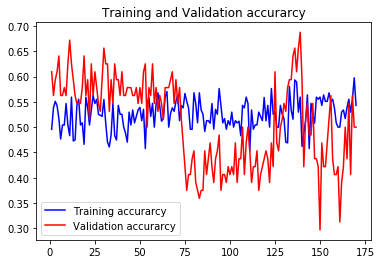

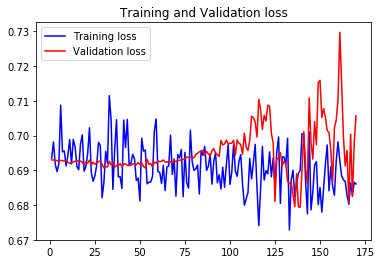

In [183]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

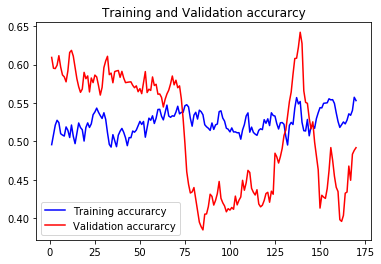

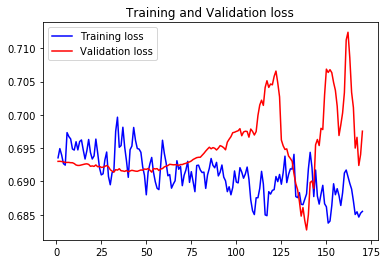

In [184]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [185]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 't2':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 't2':
            X_test.append(array)

In [186]:
x = np.array(X_test)
y = np.array(y_test)
total = len(x)
test_datagen = ImageDataGenerator(rescale=1./255)

predictions = 0
correct = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    prediction = 1 if pred > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    if prediction == actual:
        correct += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    predictions += prediction
    i += 1
    if i == total:
        break
    
print('ACCURACY: {}%'.format(correct/total * 100))
print('FALSE POSITIVE: {}%'.format(false_pos/(total-correct)))
print('FALSE NEGATIVE: {}%'.format(false_neg/(total-correct)))
print('CLINICALLY SIGNIFICANT PREDICTION: {}%'.format(predictions/total))

ACCURACY: 74.19354838709677%
FALSE POSITIVE: 0.3125%
FALSE NEGATIVE: 0.6875%
CLINICALLY SIGNIFICANT PREDICTION: 0.1935483870967742%
